In [1]:
import tensorflow as tf
import keras
from keras.layers import Dense, Flatten
from keras.layers import MaxPooling2D, Dropout
import numpy as np
import numpy.random as random
import pylab as plt
from keras.datasets import mnist, cifar10
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
from sklearn.svm import LinearSVC
from datetime import datetime
import matplotlib

Using TensorFlow backend.


In [0]:
def get_model(lr=0.01):
  sgd = keras.optimizers.SGD(lr=lr)  
  model = keras.Sequential()
  model.add(keras.layers.Dense(256, activation='relu'))
  model.add(keras.layers.Dense(256, activation='relu'))
#   model.add(keras.layers.Dense(256, activation='relu'))
  model.add(keras.layers.Dense(1, activation='sigmoid'))
  model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])
  return model

def get_lin_model(lr=0.01):
  nesterov = keras.optimizers.SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)  
  model = keras.Sequential()
  model.add(keras.layers.Dense(1, activation='sigmoid'))
  model.compile(optimizer=nesterov, loss='binary_crossentropy', metrics=['accuracy'])
  return model

##
## Information Computations
##

# estimate I(M(x); y | L(x))
def estimate_IMYL(model, linModel, x, y):
    p = est_density(model, linModel, x, y)
    return I_XYZ(p)

def est_density_MYL(model, linModel, x, y):
    Mx = np.round(model.predict(x)).flatten()
    Lx = np.round(linModel.predict(x)).flatten()
    y = y.flatten()
    
    p = est_density(Mx, y, Lx)
    return p
    
def est_density(X, Y, Z): # estimate p[x,y,z] \in R^{{0,1}^3} for samples from X, Y, Z \in \N
    X = X.astype(int)
    Y = Y.astype(int)
    Z = Z.astype(int)
    
    n = len(X)
    p = np.zeros((2, 2, 2)) # p[x,y,z] is the joint prob density
    for i in range(n):
        p[X[i], Y[i], Z[i]] += 1.0
    p /= n
    return p

def I_XYZ(p): # compute I(X, Y | Z) for joint density p[x, y, z]
    pz = np.sum(p, axis=(0,1), keepdims=True) # the density of z. pz[x,y,z] = p(z)
    
    p_xy_z = p / pz  # q[x, y, z] = p(x, y | z)
    p_x_z =  np.sum(p, axis=1, keepdims=True) / pz  # p(x | z)
    p_y_z =  np.sum(p, axis=0, keepdims=True) / pz  # p(y | z)
    
    I = np.sum(p * np.nan_to_num(np.log2( p_xy_z / (p_x_z * p_y_z) )))
    return I


# returns I(A; B) where A, B \in {X, Y, Z} spefice by idx
# eg, I(X; Y) = I_ab(p, idx=[0, 1])
#     I(X; Z) = I_ab(p, idx=[0, 2])
def I_ab(p, idx=(0,1)): 
    exlude = (0+1+2) - np.sum(idx)
    p_ab = np.sum(p, axis=exlude)
    p_a = np.sum(p_ab, axis=1, keepdims=True)
    p_b = np.sum(p_ab, axis=0, keepdims=True)
    
    I = np.sum(p_ab * np.nan_to_num(np.log2( p_ab / (p_a * p_b) )))
    return I

def H(q): # binary entropy
    return -q*np.log2(q) - (1-q)*np.log2(1-q)


In [0]:
d = 100
w = np.random.randn(d)
w /= np.linalg.norm(w) 
w_p = np.random.randn(d)    # take a random vector
w_p -= w_p.dot(w) * w       # make it orthogonal to w
w_p /= np.linalg.norm(w_p) 

# """
def get_sin_data(n):
  x = np.random.randn(n, d)
#   w = np.random.randn(d)

  y = (w.dot(x.T) + 1.7*np.sin(1.7*w_p.dot(x.T))) > 0
#   y = w.dot(x.T) > 0
  return x,y
# """

# def get_sin_data(n):
#   x = np.random.randn(n, d)
# #   w = np.random.randn(d)
#   y = np.sin(2.2*w.dot(x.T)) > 0
# #   y = w.dot(x.T) > 0
#   return x,y


def get_lin_data(n):
  x = np.random.randn(n, d)
#   w = np.random.randn(d)
  y = w.dot(x.T) > 0
#   y = w.dot(x.T) > 0
  return x,y



In [50]:
x_train, y_train = get_sin_data(50000)
x_test, y_test = get_sin_data(10000)
lin = get_lin_model(0.001)

lin.fit(x_train, y_train,
         batch_size=32,
         epochs=20,
         shuffle=True, 
         validation_data=(x_test, y_test))


Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 3s 56us/step - loss: 0.5590 - acc: 0.7376 - val_loss: 0.4829 - val_acc: 0.8038
Epoch 2/20
50000/50000 [==============================] - 2s 36us/step - loss: 0.4751 - acc: 0.8085 - val_loss: 0.4784 - val_acc: 0.8044
Epoch 3/20
50000/50000 [==============================] - 2s 37us/step - loss: 0.4730 - acc: 0.8075 - val_loss: 0.4783 - val_acc: 0.8027
Epoch 4/20
50000/50000 [==============================] - 2s 37us/step - loss: 0.4730 - acc: 0.8068 - val_loss: 0.4782 - val_acc: 0.8049
Epoch 5/20
50000/50000 [==============================] - 2s 37us/step - loss: 0.4729 - acc: 0.8071 - val_loss: 0.4783 - val_acc: 0.8039
Epoch 6/20
50000/50000 [==============================] - 2s 37us/step - loss: 0.4728 - acc: 0.8072 - val_loss: 0.4780 - val_acc: 0.8039
Epoch 7/20
50000/50000 [==============================] - 2s 36us/step - loss: 0.4728 - acc: 0.8085 - val_loss: 0.4781 - val_acc

KeyboardInterrupt: ignored

In [0]:
x_train, y_train = get_sin_data(50000)
x_test, y_test = get_sin_data(2000)

In [54]:
model = get_model(0.01)
model.fit(x_train, y_train,
         batch_size=32,
         epochs=100,
         shuffle=True, 
         validation_data=(x_test, y_test))


Train on 50000 samples, validate on 2000 samples
Epoch 1/100
50000/50000 [==============================] - 5s 109us/step - loss: 0.5354 - acc: 0.7533 - val_loss: 0.4756 - val_acc: 0.7930
Epoch 2/100
50000/50000 [==============================] - 4s 85us/step - loss: 0.4794 - acc: 0.7997 - val_loss: 0.4691 - val_acc: 0.8035
Epoch 3/100
50000/50000 [==============================] - 4s 86us/step - loss: 0.4694 - acc: 0.8066 - val_loss: 0.4663 - val_acc: 0.8090
Epoch 4/100
50000/50000 [==============================] - 4s 86us/step - loss: 0.4614 - acc: 0.8138 - val_loss: 0.4614 - val_acc: 0.8080
Epoch 5/100
50000/50000 [==============================] - 4s 84us/step - loss: 0.4529 - acc: 0.8188 - val_loss: 0.4537 - val_acc: 0.8170
Epoch 6/100
50000/50000 [==============================] - 4s 83us/step - loss: 0.4415 - acc: 0.8256 - val_loss: 0.4415 - val_acc: 0.8215
Epoch 7/100
50000/50000 [==============================] - 4s 84us/step - loss: 0.4192 - acc: 0.8355 - val_loss: 0.4119 - 

KeyboardInterrupt: ignored

In [0]:
times = 10
epochs = 25


model_acc = np.zeros((times, epochs))
I_MYL = np.zeros((times, epochs))
# I_ML = np.zeros((times, epochs))
I_MY = np.zeros((times, epochs))
I_MY_train = np.zeros((times, epochs))

# num_of_batches = 10
# batch_size = int(len(x_train) / num_of_batches)
for t in range(times):
  model = get_model()
  print("time number ", t)

  for ep in range(epochs):
      print("Starting epoch", ep ,"at time: ", str(datetime.now().time()))
      #learnt, r_acc = train_linear(model, epochs=30, verbose=False)
      #repro_acc.append(r_acc)

      pMYL = est_density_MYL(model, lin, x_test, y_test)  # p[M, Y, L]
      I_MYL[t, ep] = I_XYZ(pMYL)
      I_MY[t, ep] = I_ab(pMYL, idx=(0, 1))
      
      pMYL_train = est_density_MYL(model, lin, x_train, y_train)  # p[M, Y, L]
      I_MY_train[t, ep] = I_ab(pMYL_train, idx=(0, 1))
      
      model_loss, m_acc = model.evaluate(x_test, y_test)
      model_acc[t, ep] = m_acc
      model.fit(x_train, y_train, batch_size=32, epochs=1, verbose=0)

#       print("DONE WITH EPOCH: ", ep)
#       print("\n")
# ax2.set_yticks(ytx2)


plt.rcParams["font.family"] = 'serif'
eps = epochs

gap = I_MY - I_MYL
_, lin_acc = lin.evaluate(x_test, y_test)

fig, ax1 = plt.subplots()
# ax1.plot(range(eps), gap.mean(axis=0), label='I(Model(x); Y) - I(Model(x); Y | Lin(x))')
ax1.plot(range(eps), gap.mean(axis=0), label='I(F$_t$; Y) - I(F$_t$; Y | Lin)')
ax1.fill_between(range(eps), gap.mean(axis=0)-gap.std(axis=0), gap.mean(axis=0)+gap.std(axis=0), alpha=0.4)
# ax1.plot(range(eps), I_MY.mean(axis=0), label='I(Model(x); Y)')
ax1.plot(range(eps), I_MY.mean(axis=0), label='I(F$_t$; Y)')
ax1.fill_between(range(eps), I_MY.mean(axis=0)-I_MY.std(axis=0), I_MY.mean(axis=0)+I_MY.std(axis=0), alpha=0.4)

ax1.plot(range(eps), I_MY_train.mean(axis=0), label='I(F$_t$; Y$_S$)')
ax1.fill_between(range(eps), I_MY_train.mean(axis=0)-I_MY_train.std(axis=0), I_MY_train.mean(axis=0)+I_MY_train.std(axis=0), alpha=0.4)


# ax1.plot(range(eps), I_LYM.mean(axis=0), label='I(Lin(x); Y | Model(x))')
# ax1.plot(range(eps), I_LYM.mean(axis=0), label='I(L(x); Y | M(x))')
# ax1.fill_between(range(eps), I_LYM.mean(axis=0)-I_LYM.std(axis=0), I_LYM.mean(axis=0)+I_LYM.std(axis=0), alpha=0.3)

ax1.plot(range(eps), (1-H(lin_acc))*np.ones(eps), linestyle='--', linewidth=1, label='Best Linear', color='C0')

plt.text(range(eps)[-10],  (1-H(lin_acc))+0.015, 'Best Linear')

# ax1.plot(range(eps), (1-H(lin_acc))*np.ones(eps), linestyle='--', linewidth=1, label='Best Linear', color='C0')

# plt.text(range(eps)[-50],  (1-H(lin_acc))+0.015, 'Best Linear'

plt.xlabel("SGD epochs")
plt.ylabel("High Dimensional Sinusoid - Mutual-Information")
# plt.grid(True, axis='y')

# ax1.legend()
ax1.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))

ax2 = ax1.twinx()
ax2.plot(ax1.get_ylim(), alpha=0)
ax2.set_ylabel("Accuracy")
ax2.set_ylim(ax1.get_ylim())

# l = ax1.get_ylim()
# l2 = ax2.get_ylim()
labels = np.array([0.5, 0.6, 0.7, 0.8, 0.9, 0.99])
# f = lambda x : l2[0]+(x-l[0])/(l[1]-l[0])*(l2[1]-l2[0])
# ticks = f(1-H(labels))
ax2.yaxis.set_major_locator(matplotlib.ticker.FixedLocator(1-H(labels)))
ax2.set_yticklabels(labels)
plt.title('Mnist, 0-4 vs 5-9 - Mutual-Information')

labels = np.linspace(0.5, 1, 6)



# ax2.set_yticks(ytx2)
fig.tight_layout()

time number  0
Starting epoch 0 at time:  11:52:16.826475
2000/2000 [==============================] - 0s 245us/step
Starting epoch 1 at time:  11:52:25.838145
2000/2000 [==============================] - 0s 41us/step
Starting epoch 2 at time:  11:52:32.546188
2000/2000 [==============================] - 0s 40us/step
Starting epoch 3 at time:  11:52:39.133766
2000/2000 [==============================] - 0s 39us/step
Starting epoch 4 at time:  11:52:45.474647
2000/2000 [==============================] - 0s 38us/step
Starting epoch 5 at time:  11:52:51.798092
2000/2000 [==============================] - 0s 37us/step
Starting epoch 6 at time:  11:52:58.161288
2000/2000 [==============================] - 0s 41us/step
Starting epoch 7 at time:  11:53:04.378424
2000/2000 [==============================] - 0s 39us/step
Starting epoch 8 at time:  11:53:10.633702
2000/2000 [==============================] - 0s 38us/step
Starting epoch 9 at time:  11:53:16.856117
2000/2000 [=====================

2000/2000 [==============================] - 0s 27us/step


/usr/local/lib/python3.6/dist-packages/matplotlib/tight_layout.py:181: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. '


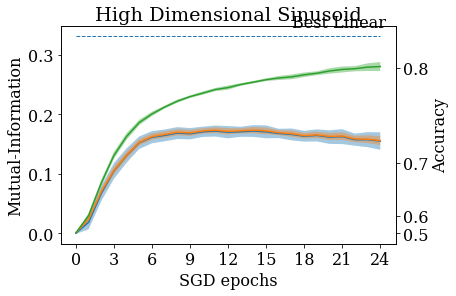

In [15]:
fig.tight_layout()

plt.rcParams["font.family"] = 'serif'
plt.rcParams.update({'font.size': 16})
eps = epochs

gap = I_MY - I_MYL
_, lin_acc = lin.evaluate(x_test, y_test)

fig, ax1 = plt.subplots()
# ax1.plot(range(eps), gap.mean(axis=0), label='I(Model(x); Y) - I(Model(x); Y | Lin(x))')
ax1.plot(range(eps), gap.mean(axis=0), label='I(F$_t$; Y) - I(F$_t$; Y | Lin)')
ax1.fill_between(range(eps), gap.mean(axis=0)-gap.std(axis=0), gap.mean(axis=0)+gap.std(axis=0), alpha=0.4)
# ax1.plot(range(eps), I_MY.mean(axis=0), label='I(Model(x); Y)')
ax1.plot(range(eps), I_MY.mean(axis=0), label='I(F$_t$; Y)')
ax1.fill_between(range(eps), I_MY.mean(axis=0)-0.5*I_MY.std(axis=0), I_MY.mean(axis=0)+0.5*I_MY.std(axis=0), alpha=0.4)

ax1.plot(range(eps), I_MY_train.mean(axis=0), label='I(F$_t$; Y$_S$)')
ax1.fill_between(range(eps), I_MY_train.mean(axis=0)-0.5*I_MY_train.std(axis=0), I_MY_train.mean(axis=0)+0.5*I_MY_train.std(axis=0), alpha=0.4)


# ax1.plot(range(eps), I_LYM.mean(axis=0), label='I(Lin(x); Y | Model(x))')
# ax1.plot(range(eps), I_LYM.mean(axis=0), label='I(L(x); Y | M(x))')
# ax1.fill_between(range(eps), I_LYM.mean(axis=0)-I_LYM.std(axis=0), I_LYM.mean(axis=0)+I_LYM.std(axis=0), alpha=0.3)

ax1.plot(range(eps), (1-H(lin_acc))*np.ones(eps), linestyle='--', linewidth=1, label='Best Linear', color='C0')

plt.text(range(eps)[-8],  (1-H(lin_acc))+0.015, 'Best Linear')

# ax1.plot(range(eps), (1-H(lin_acc))*np.ones(eps), linestyle='--', linewidth=1, label='Best Linear', color='C0')

# plt.text(range(eps)[-50],  (1-H(lin_acc))+0.015, 'Best Linear'

plt.xlabel("SGD epochs")
plt.ylabel("Mutual-Information")
# plt.grid(True, axis='y')

# ax1.legend()
ax1.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))

ax2 = ax1.twinx()
ax2.plot(ax1.get_ylim(), alpha=0)
ax2.set_ylabel("Accuracy")
ax2.set_ylim(ax1.get_ylim())

# l = ax1.get_ylim()
# l2 = ax2.get_ylim()
labels = np.array([0.5, 0.6, 0.7, 0.8, 0.9, 0.99])
# f = lambda x : l2[0]+(x-l[0])/(l[1]-l[0])*(l2[1]-l2[0])
# ticks = f(1-H(labels))
ax2.yaxis.set_major_locator(matplotlib.ticker.FixedLocator(1-H(labels)))
ax2.set_yticklabels(labels)
plt.title('High Dimensional Sinusoid')

labels = np.linspace(0.5, 1, 6)

In [1]:
first_idx = np.where(I_MY.mean(axis=0) > 1-H(lin_acc))[0][0]
print (gap.mean(axis=0)[first_idx] /( 1-H(lin_acc)))
gap.mean(axis=0)[-1] / I_MY.mean(axis=0)[-1]

NameError: ignored

In [1]:
1-H(lin_acc)

NameError: ignored

In [33]:
( 1-H(lin_acc[0])

SyntaxError: ignored

In [0]:
mu.mean(axis=0)[first_idx] / (1-H(lin_acc))
mu.mean(axis=0)[-1] / I_MY.mean(axis=0)[-1]

0.3017191088653761

In [0]:
lin.evaluate(x_test, y_test)

1000/1000 [==============================] - 0s 65us/step


[0.5605549945831299, 0.849]